## Computing climate indicators with xclim

The Climate Impact Lab Downscaled Projections for Climate Impacts Research (CIL-GDPCR) collections contain bias corrected and downscaled 1/4° CMIP6 projections for temperature and precipitation.

See the project homepage for more information: [github.com/ClimateImpactLab/downscaleCMIP6](https://github.com/ClimateImpactLab/downscaleCMIP6).

This tutorial covers constructing a time series across the CMIP:historical and ScenarioMIP:ssp126 experiments, and computing transformations using the [xclim](https://xclim.readthedocs.io/) package. Additional tutorials are available at [github.com/microsoft/PlanetaryComputerExamples](https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/cil-gdpcir).

Try it live on Binder:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ClimateImpactLab/downscaleCMIP6-binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252FClimateImpactLab%252FPlanetaryComputerExamples%26urlpath%3Dlab%252Ftree%252FPlanetaryComputerExamples%252Fdatasets%252Fcil-gdpcir%252indicators.ipynb%26branch%3Dgdpcir-additional-notebooks)

In [1]:
# required to locate and authenticate with the stac collection
import planetary_computer
import pystac_client
import pystac

# required to load a zarr array using xarray
import xarray as xr

# climate indicators with xclim
import xclim.indicators

# optional imports used in this notebook
from dask.diagnostics import ProgressBar

### Building a joint historical and projection time series

Let's work with the FGOALS-g3 historical and ssp1-2.6 simulations

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)

In [3]:
collection_cc0 = pystac.read_file(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/collections/cil-gdpcir-cc0"  # noqa
)
collection_cc0

<Collection id=cil-gdpcir-cc0>

In [4]:
collection_cc0.summaries.to_dict()

{'cmip6:variable': ['pr', 'tasmax', 'tasmin'],
 'cmip6:source_id': ['FGOALS-g3', 'INM-CM4-8', 'INM-CM5-0'],
 'cmip6:experiment_id': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'cmip6:institution_id': ['BCC',
  'CAS',
  'CCCma',
  'CMCC',
  'CSIRO',
  'CSIRO-ARCCSS',
  'DKRZ',
  'EC-Earth-Consortium',
  'INM',
  'MIROC',
  'MOHC',
  'MPI-M',
  'NCC',
  'NOAA-GFDL',
  'NUIST']}

In [5]:
fgoals_hist_items = catalog.search(
    collections=["cil-gdpcir-cc0"],
    query={
        "cmip6:source_id": {"eq": "FGOALS-g3"},
        "cmip6:experiment_id": {"eq": "historical"},
    },
).get_all_items()

fgoals_ssp126_items = catalog.search(
    collections=["cil-gdpcir-cc0"],
    query={
        "cmip6:source_id": {"eq": "FGOALS-g3"},
        "cmip6:experiment_id": {"eq": "ssp126"},
    },
).get_all_items()

time_series = fgoals_hist_items + fgoals_ssp126_items

In [6]:
[item.common_metadata.object.id for item in time_series]

['cil-gdpcir-CAS-FGOALS-g3-historical-r1i1p1f1-day',
 'cil-gdpcir-CAS-FGOALS-g3-ssp126-r1i1p1f1-day']

Retrieve object URLs by authenticating with Planetary Computer

In [7]:
# use the planetary computer API to sign the asset
signed_items = [planetary_computer.sign(item) for item in time_series]

In [8]:
# select this variable ID for all models in the collection
variable_id = "tasmin"

In [9]:
# get the API key and other important keyword arguments
open_kwargs = signed_items[0].assets[variable_id].extra_fields["xarray:open_kwargs"]

### Reading a single variable

In [10]:
ds = xr.open_mfdataset(
    [item.assets[variable_id].href for item in signed_items],
    combine="by_coords",
    combine_attrs="drop_conflicts",
    parallel=True,
    **open_kwargs,
)

In [11]:
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 55115)
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 360, 360), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                  CF-1.7 CMIP-6.2
    contact:                      climatesci@rhg.com
    data_specs_version:           01.00.31
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    dc6_citation:                 Please refer to https://github.com/ClimateI...
    dc6_creation_date:            2022-01-25
    ...                           ...
    source_type:                  AOGCM
    sub_experiment:               none
    sub_experiment_id:            none
    table_id:                     day
    variable_id:                  tasmin
    variant_label:                r1i1p1f1

Let's take a look at the variable `tasmin`. Note the summary provided by the dask preview. This array is 213 GB in total, in 180 MB chunks. The data is chunked such that each year and 90 degrees of latitude and longitude form a chunk.

To read in the full time series for a single point, you'd need to work through 180.45 MB/chunk * 151 annual chunks = 27 GB of data. This doesn't all need to be held in memory, but it gives a sense of what the operation might look like in terms of download & compute time.

In [12]:
ds.tasmin

<xarray.DataArray 'tasmin' (time: 55115, lat: 720, lon: 1440)>
dask.array<concatenate, shape=(55115, 720, 1440), dtype=float32, chunksize=(365, 360, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-31 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: minimum (interval: 10 minutes)
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    coordinates:    height
    long_name:      Daily Minimum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

### Applying a climate indicator from xclim

The [`xclim`](https://xclim.readthedocs.io) package provides a large number of useful [indicators](https://xclim.readthedocs.io/en/stable/indicators.html) for analyzing climate data. Here, we'll use the Atmospheric Indicator: [Frost Days (`xclim.indicators.atmos.frost_days`)](https://xclim.readthedocs.io/en/stable/indicators_api.html#xclim.indicators.atmos.frost_days):

In [13]:
frost_days = xclim.indicators.atmos.frost_days(ds=ds)

In [14]:
frost_days

<xarray.DataArray 'frost_days' (time: 151, lat: 720, lon: 1440)>
dask.array<where, shape=(151, 720, 1440), dtype=float64, chunksize=(1, 360, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-01-01 00:00:00 ... 2100-01-01 00:00:00
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    units:          days
    cell_methods:   area: mean time: minimum (interval: 10 minutes) time: sum...
    history:        [2022-04-15 13:53:43] frost_days: FROST_DAYS(tasmin=tasmi...
    standard_name:  days_with_air_temperature_below_threshold
    long_name:      Number of frost days (tmin < 0 degc)
    description:    Annual number of days with minimum daily temperature belo...

Here, the state data requirement has been reduced significantly - but careful - this is the size required by the final product *once computed*. But this is a scheduled [dask](https://docs.xarray.dev/en/latest/user-guide/dask.html) operation, and because of dask's [Lazy Evaluation](https://tutorial.dask.org/01x_lazy.html), we haven't done any work yet. Dask is waiting for us to require operations, e.g. by calling `.compute()`, `.persist()`, or because of blocking opreations like writing to disk or plotting. Until we do one of those, we haven't actually read any data yet!

### Loading a subset of the data

Let's subset the data and call `.compute()` so we can work with it in locally (in the notebook).

I'll pick Oslo, Norway, as our oft-frosty location to inspect, and extract one year a decade to plot as a time series. Ideally, we'd look at all of the years and compute a statistic based on a moving multi-decadal window, but this is just an example ;)

Thanks to [Wikipedia](https://en.wikipedia.org/wiki/Oslo) for the geographic info!

In [15]:
with ProgressBar():
    oslo_frost_days_summary = (
        frost_days.sel(lat=59.913889, lon=10.752222, method="nearest").sel(
            time=frost_days.time.dt.year.isin(range(1950, 2101, 10))
        )
    ).compute()

[########################################] | 100% Completed |  1min 21.9s


In [16]:
oslo_frost_days_summary

<xarray.DataArray 'frost_days' (time: 16)>
array([131., 118., 149., 139., 165., 118., 132., 128., 118., 120., 121.,
       127., 100., 122., 118., 106.])
Coordinates:
  * time     (time) object 1950-01-01 00:00:00 ... 2100-01-01 00:00:00
    lat      float64 59.88
    lon      float64 10.88
Attributes:
    units:          days
    cell_methods:   area: mean time: minimum (interval: 10 minutes) time: sum...
    history:        [2022-04-15 13:53:43] frost_days: FROST_DAYS(tasmin=tasmi...
    standard_name:  days_with_air_temperature_below_threshold
    long_name:      Number of frost days (tmin < 0 degc)
    description:    Annual number of days with minimum daily temperature belo...

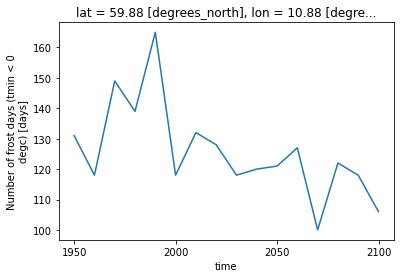

In [17]:
oslo_frost_days_summary.plot()